Lista 5 - AMA - Luis Fernando Bastos Rego - 470043
#Inicialização do modelo:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


np.random.seed(12345)

dataset = np.genfromtxt('./californiabin.csv', delimiter=',')
x = dataset[:,:-1]
y = np.reshape(dataset[:,[-1]], (-1,))

models = []
model_names = [ 'SVM', 'RANDOM FOREST:']

folds = 10

print(f"Número de amostras: {dataset.shape[0]}")
print(f"Número de dimensões: {dataset.shape[1]}")
print(f"Número de classes: {np.unique(dataset[:,[-1]]).shape[0]}")
#print(f"Número de folds: {folds}")

Número de amostras: 3000
Número de dimensões: 9
Número de classes: 2


* Separando os conjuntos dos dados dos modelos e normalizando os valores:

In [2]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#data_train_scaled = np.concatenate((x_train_scaled,y_train))
#data_test_scaled = np.concatenate((x_test_scaled,y_test))

# Treinamento e escolha dos modelos:



In [9]:
parameters_svm = {'C':list(map(lambda x: 2**x, np.arange(-5.,16.,2))) , 'gamma':list(map(lambda x: 2**x, np.concatenate((np.arange(-15.,4.,2), [2]))))}
svm_grid_search = GridSearchCV(estimator=SVC(kernel='rbf',probability=True), param_grid=parameters_svm,cv=KFold(n_splits=folds,shuffle=True)).fit(x_train_scaled,y_train)
svm_pred = svm_grid_search.predict(x_test_scaled)
svm_pred_proba = svm_grid_search.predict_proba(x_test_scaled)
models.append(svm_grid_search)

score_params = ['accuracy', 'precision', 'recall' ,'f1']
parameters_rf = {'n_estimators': np.arange(10,201,10), 'max_depth': [2,4,6,8,None]}
rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameters_rf, scoring=score_params, refit='f1',cv=KFold(n_splits=folds,shuffle=True)).fit(x_train_scaled, y_train)
rf_pred = rf_grid_search.predict(x_test_scaled)
rf_pred_proba = rf_grid_search.predict_proba(x_test_scaled)
models.append(rf_grid_search)

# Apresentação das métricas:



In [10]:
model_preds = [ svm_pred, rf_pred ]
for i in range(len(model_preds)):
    print(f"\nSummary for the classifier {model_names[i]}")
    print(metrics.classification_report(y_test, model_preds[i]))
    print(f'with the chosen parameters as follows:')
    for key in models[i].best_params_:
      print(f'{key}: {models[i].best_params_[key]};')


Summary for the classifier SVM
              precision    recall  f1-score   support

         0.0       0.84      0.83      0.84       445
         1.0       0.84      0.85      0.84       455

    accuracy                           0.84       900
   macro avg       0.84      0.84      0.84       900
weighted avg       0.84      0.84      0.84       900

with the chosen parameters as follows:
C: 4;
gamma: 0.25;

Summary for the classifier RANDOM FOREST:
              precision    recall  f1-score   support

         0.0       0.85      0.88      0.86       445
         1.0       0.88      0.84      0.86       455

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900

with the chosen parameters as follows:
max_depth: None;
n_estimators: 170;


# Curvas dos modelos:

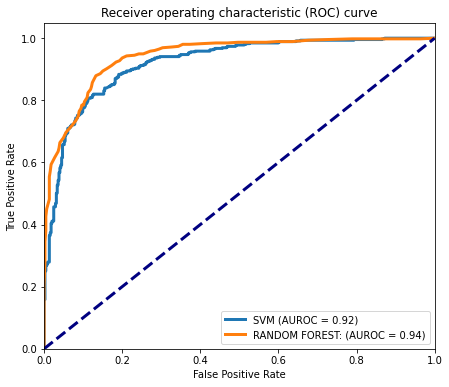

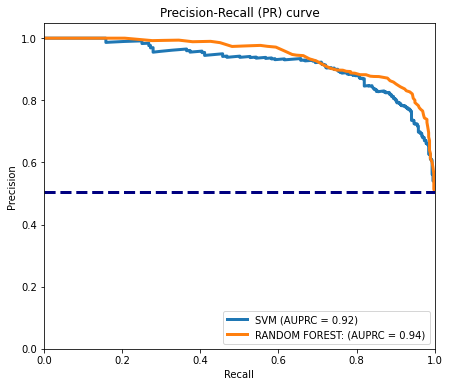

In [11]:
model_probs = [ svm_pred_proba[:,1], rf_pred_proba[:,1] ]
# Plota curva ROC    
plt.figure(figsize=(7,6))
for i in range(len(model_preds)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model_probs[i])
    plt.plot(fpr, tpr, lw=3, label=f"{model_names[i]} (AUROC = {metrics.auc(fpr, tpr):0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

# Plota curva PR    
plt.figure(figsize=(7,6))
for i in range(len(model_preds)):
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, model_probs[i])
    plt.plot(recall, precision, lw=3, label=f"{model_names[i]} (AUPRC = {metrics.auc(recall, precision):0.2f})")
positive_ratio = np.mean(y_test == 1)
plt.plot([0, 1], [positive_ratio, positive_ratio], color='navy', lw=3, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) curve')
plt.legend(loc="lower right")
plt.show()